# Analysis and prediction of Crime data as it relates to weather conditions in the city of San Francisco

- Jim Haskin

- GA-Data Science
- Dec 2015

- 2/17/2016

## Hypothisis
It is often said that people lose their temper more when it is hot out and that all the crazies come out when there is a full moon. But does the data prove these hunches are true? 
If it is true, can we look at the weather forcast for the next week and predict if the number or intensity of Police Incidents will be higher or lower than usual?

## Method
Crime Data
- I have collected the incident reports of the San Franciso Police Department from the SF OpenData website. https://data.sfgov.org/data?category=Public%20Safety. I have the records from January, 2003 until the beginning of 2016.
- I summerized the report to generate a daily report of the number of incidents and another factor I am calling Crime Level. Each incident is given a score based on how violent it is. Murders and assaults are rated high. Traffic violations and non-criminal incidents are rated low. These scores are summed and then normalized to a scale of 0 - 10.
- This was done in the `'2_clean_data_sf_crime'` notebook.
- Data written to file. `'sf_crime_clean.csv'`

Weather Data
- I collected historical weather data for the San Franciso area from January 2003 until December 2015. The data comes from Weather Underground. http://www.wunderground.com/history/
- To that data I added new features, such as the phase of the moon, that I wanted to investigate.
- This was done in the `'3_clean_weather_combine_with_crime'` notebook.
- Data written to file. `'sf_crime_weather.csv'`

Analysis and Modeling
- I looked at the crime levels as it related to different features to get a general idea of what features are important.
- Removed fields that are not in the Forecast Data that will be used for prediction.
- Build Model.......
- ...........

Prediction
- I used the WeatherUnderground API and the OpenWeatherMap API to retreive the forecast for the next 10 days in San Fransico.
- To this I added in the other relavent features such as Moon Phase.
- This is done in the `'8_get_weather_forcast'` notebook.
- Data is written to file. `'forecast_10day.csv'`
- This new data is then run throught the model to predict the general level of crime for the next 10 days.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline


## Data source Training
Data was consolidated in these two Notebooks
- 2_clean_data_sf_crime.ipynb | Data downloaded from SF Open Data site. 
- 3_clean_weather_combine_with_crime.ipynb | Data downloaded from WeatherUnderground.com
- Final file name 'sf_crime_weather.csv'


FieldName|Type|Description                             
---------------|------------|---------------------
Index:Date|DateTime|2003-01-01 to 2015-12-31
crime_level_sum|int64|Calculated Crime Level for the day
crime_level_count|int64|Number of incidents for the day
crime_level|float64|Crime level scaled to 0-10
dayofweek|object|Day of the week in string format
day|int64|Day of month in numeric
month|int64|Month of year in numeric
year|int64|Year in numeric
temp_max|int64|High Temperature for the day in degrees F
temp_mean|int64|Mean Temperature for the day in degrees F
temp_min|int64|Low Temperature for the day in degrees F
temp_delta|int64|Temperature change for the day in degrees F
dew_point_max|int64|High Dew Point for the day in degrees F
dew_point_mean|int64|Mean Dew Point for the day in degrees F
dew_point_min|int64|Low Dew Point for the day in degrees F
humidity_max|int64|Maximum Humidity for the day in percentage
humidity_mean|int64|Mean Humidity for the day in percentage
humidity_min|int64|Minimum Humidity for the day in percentage
sl_pressure_max|float64|High Sea Level for the day in inches
sl_pressure_mean|float64|Mean Sea Level for the day in inches
sl_pressure_min|float64|Low Sea Level for the day in inches
wind_speed_max|int64|Maximum maintained Wind Speed in mph
wind_speed_mean|int64|Mean maintained Wind Speed in mph
wind_max_gust|float64|Maximum Wind Gust in mph
precipitation|float64|Amount is precipitation in inches
cloud_cover|int64|Cloud Cover in percentage
events|object|Significant Events such as 'Rain', 'Fog'
wind_direction|int64|General wind direction, numeric 0 359
sun_length|float64|Number of minutes of Sun on day
moon_phase|float64|Phase moon is in. 0.5 = full moon
sun_units|float64|the minutes of Sun scaled by the cloud cover percentage


## Read in combined Data and investigate

In [2]:
data = pd.read_csv('sf_crime_weather.csv', index_col=0)
data.head(5)

,crime_level_sum,crime_level_count,crime_level,dayofweek,day,month,year,temp_max,temp_mean,temp_min,...,wind_speed_max,wind_speed_mean,wind_max_gust,precipitation,cloud_cover,events,wind_direction,sun_length,moon_phase,sun_units
2003-01-01,1254,622,10.000000,wednesday,1,1,2003,52,48,43,...,9,2,NaN,0.00,37,No,86,578.733333,0.950084,364.602000
2003-01-02,750,411,5.974441,thursday,2,1,2003,54,50,46,...,8,3,NaN,0.00,62,No,79,579.400000,0.983944,220.172000
2003-01-03,799,440,6.365815,friday,3,1,2003,55,50,46,...,8,3,NaN,0.00,50,No,56,580.100000,0.017763,290.050000
2003-01-04,674,347,5.367412,saturday,4,1,2003,57,52,48,...,9,3,NaN,0.00,50,Fog,295,580.866667,0.051546,290.433333
2003-01-05,755,377,6.014377,sunday,5,1,2003,55,52,48,...,8,3,NaN,0.01,50,Fog,22,581.700000,0.085328,290.850000


In [3]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 4745 entries, 2003-01-01 to 2015-12-31
Data columns (total 30 columns):
crime_level_sum      4745 non-null int64
crime_level_count    4745 non-null int64
crime_level          4745 non-null float64
dayofweek            4745 non-null object
day                  4745 non-null int64
month                4745 non-null int64
year                 4745 non-null int64
temp_max             4745 non-null int64
temp_mean            4745 non-null int64
temp_min             4745 non-null int64
temp_delta           4745 non-null int64
dew_point_max        4745 non-null int64
dew_point_mean       4745 non-null int64
dew_point_min        4745 non-null int64
humidity_max         4745 non-null int64
humidity_mean        4745 non-null int64
humidity_min         4745 non-null int64
sl_pressure_max      4745 non-null float64
sl_pressure_mean     4745 non-null float64
sl_pressure_min      4745 non-null float64
wind_speed_max       4745 non-null int64
wind_speed_me

### Observations
- Much of the data was cleaned in the previous work.
- There are 4744 obsevations.
- The only values missing are ~10% of the Maximum Wind Gust feature. NOTE: (May not be needed)
- The catagorical need to be typed.


## Clean Data

### Catagoricals

In [4]:
#data['events'].fillna('No', inplace=True)
data['events'] = data['events'].astype('category')



In [5]:
data.describe()

,crime_level_sum,crime_level_count,crime_level,day,month,year,temp_max,temp_mean,temp_min,temp_delta,...,sl_pressure_min,wind_speed_max,wind_speed_mean,wind_max_gust,precipitation,cloud_cover,wind_direction,sun_length,moon_phase,sun_units
count,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,...,4745.000000,4745.000000,4745.000000,4280.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000
mean,734.103899,392.012223,5.847475,15.733193,6.521812,2009.000000,65.849947,58.662803,51.171760,14.678188,...,29.971153,22.229715,9.836670,28.221262,0.047181,44.920759,246.122234,732.011640,0.512256,406.803915
std,91.623215,48.400581,0.731815,8.800513,3.449100,3.742897,8.402315,6.530743,5.707621,5.867343,...,0.142509,7.088153,4.593245,8.966108,0.191603,28.926472,71.727288,106.738169,0.288648,223.377818
min,308.000000,152.000000,2.444089,1.000000,1.000000,2003.000000,45.000000,40.000000,32.000000,2.000000,...,28.880000,5.000000,0.000000,6.000000,0.000000,0.000000,1.000000,575.300000,0.012958,0.000000
25%,674.000000,361.000000,5.367412,8.000000,4.000000,2006.000000,60.000000,54.000000,47.000000,11.000000,...,29.880000,17.000000,6.000000,23.000000,0.000000,25.000000,235.000000,628.583333,0.262623,219.329167
50%,731.000000,391.000000,5.822684,16.000000,7.000000,2009.000000,65.000000,59.000000,52.000000,14.000000,...,29.960000,23.000000,10.000000,28.000000,0.000000,50.000000,273.000000,733.233333,0.510797,412.583333
75%,789.000000,422.000000,6.285942,23.000000,10.000000,2012.000000,71.000000,63.000000,55.000000,18.000000,...,30.060000,26.000000,13.000000,32.000000,0.000000,75.000000,290.000000,835.733333,0.761123,579.466667
max,1254.000000,650.000000,10.000000,31.000000,12.000000,2015.000000,99.000000,82.000000,69.000000,39.000000,...,30.480000,60.000000,28.000000,204.000000,3.430000,100.000000,359.000000,885.650000,1.012482,885.633333


## Investigate Features

In [6]:
data['events'].value_counts()

No                   3520
Rain                  830
Fog                   323
Rain-Thunderstorm      42
Fog-Rain               26
Thunderstorm            4
dtype: int64

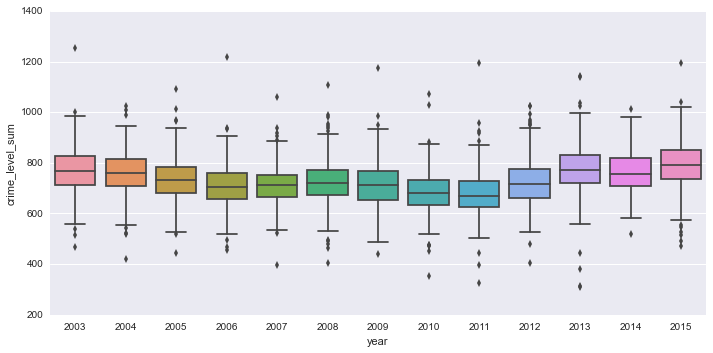

In [7]:
sb.factorplot(
    data = data,
    y = 'crime_level_sum',
    x = 'year',
    size=5, aspect=2,
    #hue = 'signup_method',   # row =   col =  hue =
    #row = 'language',
    kind = 'box'
)

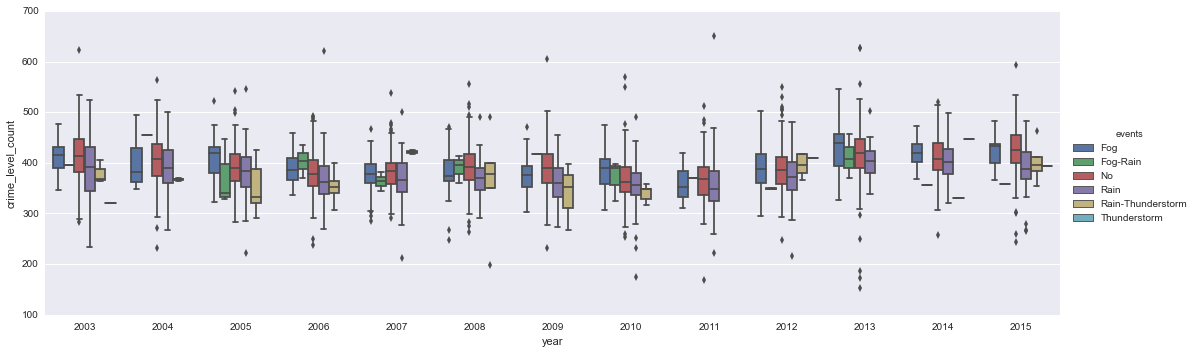

In [8]:
sb.factorplot(
    data = data,
    y = 'crime_level_count',
    x = 'year',
    size=5, aspect=3,
    hue = 'events',   # row =   col =  hue =
    #row = 'language',
    kind = 'box'    # 'strip'  'violin' 'box'
)

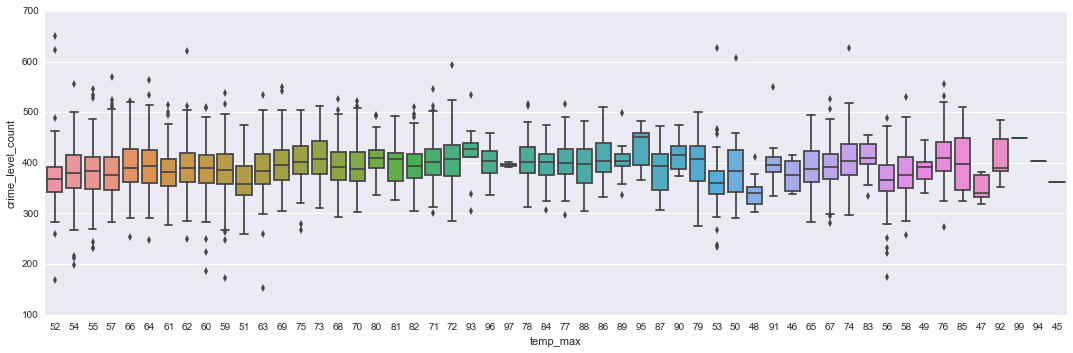

In [9]:
data.sort_values('temp_max')
sb.factorplot(
    data = data,
    y = 'crime_level_count',
    x = 'temp_max',
    size=5, aspect=3,
    #hue = 'events',   # row =   col =  hue =
    #row = 'language',
    kind = 'box'    # 'strip'  'violin' 'box'
);

# Model

# Forecast

## Data source for Forecast
Data was consolidated in Notebook
- This is done in the `'8_get_weather_forcast'` notebook. | Downloaded from Weather Underground and OpenWeatherMap
- Data is written to file. `'forecast_10day.csv'`


FieldName|Type|Description                             
---------------|------------|---------------------
Index:Date|DateTime|2003-01-01 to 2015-12-31
crime_level_sum|int64|Calculated Crime Level for the day
date|string|Format yyyy-m-d
dayofweek|object|Day of the week in string format
day|int64|Day of month in numeric
month|int64|Month of year in numeric
year|int64|Year in numeric
temp_max|int64|High Temperature for the day in degrees F
temp_mean|int64|Mean Temperature for the day in degrees F
temp_min|int64|Low Temperature for the day in degrees F
temp_delta|int64|Temperature change for the day in degrees F
humidity_mean|int64|Mean Humidity for the day in percentage
sl_pressure_mean|float64|Mean Sea Level for the day in inches
wind_speed_max|int64|Maximum maintained Wind Speed in mph
wind_speed_mean|int64|Mean maintained Wind Speed in mph
precipitation|float64|Amount is precipitation in inches
cloud_cover|int64|Cloud Cover in percentage.
events|object|Significant Events such as 'Rain', 'Fog'
wind_direction|int64|General wind direction, numeric 0 359
sun_length|float64|Number of minutes of Sun on day
moon_phase|float64|Phase moon is in. 0.5 = full moon
sun_units|float64|the minutes of Sun scaled by the cloud cover percentage

In [10]:
forecast = pd.read_csv('forecast_10day.csv', index_col=0)
forecast.head()



,date,dayofweek,day,month,year,temp_max,temp_mean,temp_min,temp_delta,sl_pressure_mean,...,wind_speed_max,wind_speed_mean,cloud_cover,percipitation,events,wind_direction,owm_status,sun_length,moon_phase,sun_units
0,2016-2-17,Wednesday,17,2,2016,65,58,52,13,29.856306,...,30,24,92,0.51,Rain,188,Clouds,654.516667,0.297417,52.361333
1,2016-2-18,Thursday,18,2,2016,59,55,52,7,29.795475,...,20,15,92,0.01,Chance of a Thunderstorm,226,Rain,656.766667,0.331351,52.541333
2,2016-2-19,Friday,19,2,2016,60,55,50,10,30.132117,...,20,13,64,0.06,Chance of Rain,197,Rain,659.050000,0.365285,237.258000
3,2016-2-20,Saturday,20,2,2016,62,56,51,11,30.295418,...,10,6,20,0.00,Partly Cloudy,336,Rain,661.316667,0.399219,529.053333
4,2016-2-21,Sunday,21,2,2016,67,59,52,15,30.473484,...,10,7,0,0.00,Clear,269,Clear,663.600000,0.433153,663.600000
